In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4)
!pip install optuna
import optuna
import os
import pandas as pd
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
!pip install catboost
import catboost
from catboost import CatBoostClassifier, Pool
from catboost import * 
from catboost import datasets
from optuna.samplers import TPESampler, RandomSampler
from optuna.integration import CatBoostPruningCallback
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import sklearn.metrics as m
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 

RAND = 1
EVAL = 'TotalF1' 

In [2]:
df = pd.read_csv('C:/Users/User/Downloads/diabetes/diabetes_012_health_indicators_BRFSS2015.csv')
df

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

В данных пропусков нет, все данные в формате float. Переведем данные в формат int. Так как это медицинские данные и они обезличены, дубликаты в таких данных допустимы

In [4]:
df[['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']] = df[['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']].astype('int')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_012          253680 non-null  int32
 1   HighBP                253680 non-null  int32
 2   HighChol              253680 non-null  int32
 3   CholCheck             253680 non-null  int32
 4   BMI                   253680 non-null  int32
 5   Smoker                253680 non-null  int32
 6   Stroke                253680 non-null  int32
 7   HeartDiseaseorAttack  253680 non-null  int32
 8   PhysActivity          253680 non-null  int32
 9   Fruits                253680 non-null  int32
 10  Veggies               253680 non-null  int32
 11  HvyAlcoholConsump     253680 non-null  int32
 12  AnyHealthcare         253680 non-null  int32
 13  NoDocbcCost           253680 non-null  int32
 14  GenHlth               253680 non-null  int32
 15  MentHlth              253680 non-n

Построим диаграмму и выясним количество здоровых, находящихся в 1 стадии заболевания и второй в процентном соотношении

(-1.25, 1.25, -1.25, 1.25)

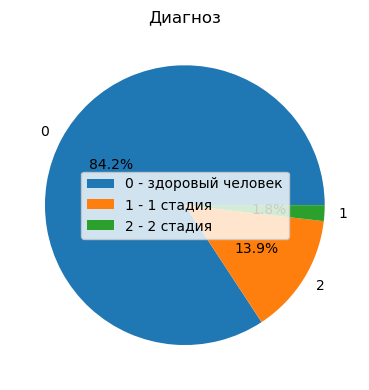

In [6]:
df.Diabetes_012.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.legend(['0 - здоровый человек', '1 - 1 стадия', '2 - 2 стадия'])
plt.title('Диагноз')
plt.tight_layout()
plt.axis('off')

Для проверки зависимости показателей построим хитмап 

<Axes: >

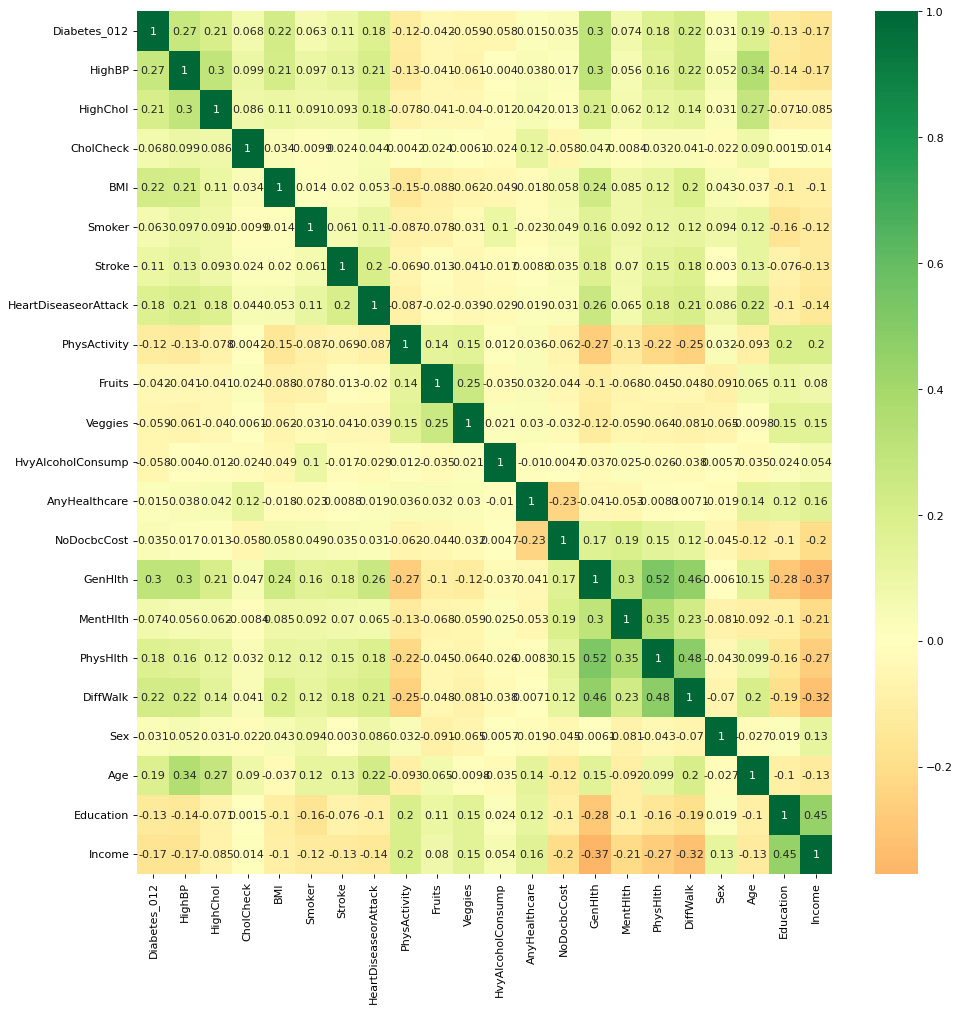

In [7]:
plt.figure(figsize=(14,14), dpi= 80)
sns.heatmap(df.corr(),  cmap='RdYlGn', center=0, annot=True)

Заштриховал поиск гиперпараметров для CatBoost

In [8]:
#train, valid = train_test_split(df, test_size=0.2, stratify=df['Diabetes_012'], random_state=RAND)
#
#train_pool = Pool (
#    train.drop('Diabetes_012', axis=1),
#    train['Diabetes_012']
#
#)
#
#valid_pool = Pool (
#    valid.drop('Diabetes_012', axis=1),
#   valid['Diabetes_012']
#)

In [9]:
#def objective(trial):
#
    # это гиперпараметры, которые будем проверять. 
#    param = {
        # suggest_int и suggest_float - непрерывные переменные. выбирает из диапазона от-до. 
        # можно ставить шаг (как стоит у регуляризации), чтоб он не тыкался +- сотые :)

#        'learning_rate':trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#        'l2_leaf_reg':trial.suggest_float('l2_leaf_reg', 2.0, 20.0, step=1),
#        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
#        'depth': trial.suggest_int('depth', 3, 12),
        
        # suggest_categorical - выбор из списка.
#        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide', 'Depthwise']),
#        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']), 
       
#    }

    # эти гиперпараметры тоже подбираем, но отдельно, в зависимости от выбранного bootstrap_type
    # если делать одним куском, то будет падать
#    if param["bootstrap_type"] == "Bayesian":
#        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif param["bootstrap_type"] == "Bernoulli":
#        param["subsample"] = trial.suggest_float("subsample", 0.1, 0.99)

#    cat_model = CatBoostClassifier(**param, 
#                                   iterations=3000,
#                                   random_state=RAND,
#                                   eval_metric=EVAL,
#                                   verbose=0, 
#                                   leaf_estimation_method='Newton',
#                                #   task_type='GPU',
#                                   early_stopping_rounds=120,  
                                #   custom_metric=['AUC', 'NormalizedGini'],
#                                   )
    
    # это интеграция. прунер - фиговинка, которая сама прервет эксперимент, если ей что-то не понравится
    # не особо давно добавили и иногда глючит. но с ним лучше
#    pruning_callback = CatBoostPruningCallback(trial, EVAL)
    
#    cat_model.fit(train_pool, eval_set=valid_pool)
    
#    pruning_callback.check_pruned()
    
    # результат в процессе оно не печатает, хоть так.
#    print(param)
#    print(cat_model.best_score_)
#    print('________________')
#    return cat_model.best_score_['validation'][EVAL]

In [10]:
#optuna.logging.set_verbosity(optuna.logging.WARNING)

# семплер - что-то типа способа подбора параметров. 
# первые раз 20 лучше запустить RandomSampler(), он работает по принципу RandomizedSearchCV из sklearn
# помогает приблизительно оценить интервалы параметров. потом в функции оптимизации порезать :)
# сам TPESampler рекомендуют запускать под сотню раз. 
#sampler = TPESampler(seed=RAND) 
# объявление процесса подбора
# для TPESampler используют прунер HyperbandPruner()
# для RandomSampler - прунер MedianPruner()
#study = optuna.create_study(study_name="catboost", 
#                            direction="maximize",
#                            pruner=optuna.pruners.HyperbandPruner(),
#                            sampler=sampler)
# study тут создается новый, а вообще можно его сохранять/загружать, 
# если хочется продолжить подбор на том же наборе данных. 

In [11]:
# это уже запуск попыток. n_trials количество. можно поставить время timeout
#study.optimize(objective, n_trials=5)

In [12]:
# красивый график важности гиперпараметров
#optuna.visualization.plot_param_importances(study)

In [13]:
# лучшая метрика
#study.best_trial.value
# гиперпараметры, для которых она достигнута
#study.best_trial.params

In [14]:
#train

In [15]:
#catboost = CatBoostClassifier(random_state=RAND, silent=True)
#catboost_params = {
#    'learning_rate': 0.09746778326527859,
#     'l2_leaf_reg': 16.0,
#     'min_data_in_leaf': 147,
#     'depth': 10,
#     'grow_policy': 'Depthwise',
#     'bootstrap_type': 'Bayesian',
#     'bagging_temperature': 1.3002857211827767
#}

#catboost.fit(train_pool, eval_set=valid_pool) 
#catboost.best_score_

In [16]:
#catboost.get_feature_importance(prettified=True)

In [17]:
df_train, df_valid = train_test_split(df, train_size=0.6, test_size=0.4, random_state=123)
df_valid, df_test = train_test_split(df_valid, train_size=0.5, test_size=0.5, random_state=123)

In [18]:
x_train = df_train.drop('Diabetes_012', axis=1)
y_train = df_train['Diabetes_012']

x_valid = df_valid.drop('Diabetes_012', axis=1)
y_valid = df_valid['Diabetes_012']

x_test = df_test.drop('Diabetes_012', axis=1)
y_test = df_test['Diabetes_012']

### Обучим Случайный лес 

In [19]:
RANDOM_STATE = 123
catboost = CatBoostRegressor(random_seed=171022, silent=True)
catboost_params = [{
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [1, 5, 10],
    'l2_leaf_reg': [1, 5, 9],
    'random_state': [RANDOM_STATE],
    'iterations': [100, 500, 1000]
}]

scoring='neg_mean_squared_error' 
catboost.fit(x_train, y_train)
catboost.best_score_

{'learn': {'RMSE': 0.6004759870138145}}

In [21]:
#catboost = CatBoostRegressor(random_state=123, silent=True)
#catboost_params = [{
#    'learning_rate': [0.01, 0.03, 0.1],
#    'depth': [1, 5, 10],
#    'l2_leaf_reg': [1, 5, 9],
#    'random_state': [123],
#    'iterations': [100, 500, 1000]
#}]


#grid_search_catboost = GridSearchCV(catboost,
#                                   catboost_params,
#                                   verbose=3,
#                                   cv=5,
#                                   n_jobs=-1,
#                                   scoring='neg_mean_squared_error')
#grid_search_catboost.fit(x_train, y_train) 
#grid_search_catboost.best_score_

In [22]:
result_rf =[]
for depth in range(1, 11):
    for est in range(10, 101, 10):
        model = RandomForestClassifier(random_state=123, n_estimators=est, max_depth=depth)
        model.fit(x_train, y_train)
        predictions_valid = model.predict(x_valid)
        accuracy_valid = accuracy_score(y_valid, predictions_valid)
        result_rf.append({'Model name': 'RandomForestClassifier',
                         'Hyperparameters': {'random_state':123,
                                            'n_estimators': est,
                                            'max_depth': depth},
                         'Accuracy score': accuracy_valid})

In [23]:
df_rf = pd.DataFrame.from_dict(result_rf)
df_rf[df_rf['Accuracy score'] == df_rf['Accuracy score'].max()]

,Model name,Hyperparameters,Accuracy score
94,RandomForestClassifier,"{'random_state': 123, 'n_estimators': 50, 'max...",0.849476


In [24]:
best_results = []
best_results.append(df_rf.loc[94])

### Обучим дерево решений

In [25]:
result_dt = []
for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=123, max_depth=depth)
    model.fit(x_train, y_train)
    predictions_valid = model.predict(x_valid)
    accuracy_valid = accuracy_score(y_valid, predictions_valid)
    result_dt.append({'Model name': 'DecisionTreeClassifier',
                     'Hyperparameters': {'random_state': 123, 'max_depth':depth},
                                        'Accuracy score': accuracy_valid})

In [26]:
df_dt = pd.DataFrame.from_dict(result_dt)
df_dt[df_dt['Accuracy score'] == df_dt['Accuracy score'].max()]  

,Model name,Hyperparameters,Accuracy score
6,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 7}",0.849062


In [27]:
best_results.append(df_dt.loc[6])

### Обучим Логическую регрессию

In [28]:
results_lr = []
model_lr = LogisticRegression(random_state=123, solver='liblinear', penalty='l1', C=0.001)
model_lr.fit(x_train, y_train)
predictions_lr = model_lr.predict(x_valid)
accuracy_lr = accuracy_score(y_valid, predictions_lr)
results_lr.append({'Model name': 'LogisticRegression',
                 'Hyperparameters': {'random_state': 123, 'solver':'liblinear', 'penalty': 'l1'},
                 'Accuracy score': accuracy_lr})

In [29]:
df_lr = pd.DataFrame.from_dict(results_lr)
df_lr[df_lr['Accuracy score'] == df_lr['Accuracy score'].max()]

,Model name,Hyperparameters,Accuracy score
0,LogisticRegression,"{'random_state': 123, 'solver': 'liblinear', '...",0.844883


In [30]:
best_results.append(df_lr.loc[0])

In [31]:
pd.DataFrame(best_results)

,Model name,Hyperparameters,Accuracy score
94,RandomForestClassifier,"{'random_state': 123, 'n_estimators': 50, 'max...",0.849476
6,DecisionTreeClassifier,"{'random_state': 123, 'max_depth': 7}",0.849062
0,LogisticRegression,"{'random_state': 123, 'solver': 'liblinear', '...",0.844883
